### 实战 Kaggle 比赛：预测房价

In [1]:
# 实现几个函数来方便下载数据

# 导入必要的库
import hashlib
import os
import tarfile
import zipfile
import requests

# 定义数据存储信息
DATA_HUB = dict()  # 数据源字典，存储文件名到下载URL和SHA-1哈希值的映射
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'  # 基础数据下载URL前缀


def download(name, cache_dir=os.path.join('..', 'data')):
    """下载一个DATA_HUB中的文件，返回本地文件名"""

    # 检查文件名是否存在于数据源字典中
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"

    # 获取文件的下载URL和SHA-1哈希值
    url, sha1_hash = DATA_HUB[name]

    # 确保缓存目录存在，不存在则创建
    os.makedirs(cache_dir, exist_ok=True)

    # 生成本地文件路径
    fname = os.path.join(cache_dir, url.split('/')[-1])

    # 如果本地文件已存在
    if os.path.exists(fname):
        sha1 = hashlib.sha1()  # 创建SHA-1哈希对象
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)  # 逐块读取文件内容
                if not data:
                    break
                sha1.update(data)  # 更新哈希值
        # 比较计算得到的哈希值与预定义哈希值是否相等
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存，返回文件路径

    # 如果文件不存在或哈希值不匹配，进行下载
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)  # 发起HTTP GET请求
    with open(fname, 'wb') as f:
        f.write(r.content)  # 将下载内容写入文件
    return fname  # 返回下载的文件路径

In [2]:
# 两个实用函数：一个将下载并解压缩一个zip或tar文件，另一个是将本书中使用的所有数据集从`DATA_HUB`下载到缓存目录中。
def download_extract(name, folder=None):
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

### 访问和读取数据集

**注意，竞赛数据分为训练集和测试集。每条记录都包括房屋的属性值和属性**，如街道类型、施工年份、屋顶类型、地下室状况等。**这些特征由各种数据类型组成**。例如，建筑年份由整数表示，屋顶类型由**离散**类别表示，其他特征由**浮点数**表示。**这就是现实让事情变得复杂的地方：例如，一些数据完全丢失了，缺失值被简单地标记为“NA”**。每套房子的价格只出现在训练集中（毕竟这是一场比赛）。我们将希望划分训练集以创建**验证集，但是**在将预测结果上传到Kaggle之后，我们只能在官方测试集中评估我们的模型。在比赛界面的"Data"选项卡有下载数据的链接，我们需要下载数据

In [3]:
# 使用pandas读入并处理数据
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (DATA_URL + 'kaggle_house_pred_train.csv',
                                  '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (DATA_URL + 'kaggle_house_pred_test.csv',
                                 'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [4]:
# 前两个和最后两个特征，以及相应标签（房价）
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [5]:
# 在每个样本中，第一个特征是 ID，我们将其从数据集中删除
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

### 数据预处理

在开始建模之前，我们需要对数据进行预处理。首先，我们**将所有缺失的值替换为相应特征的平均值。**然后，为了将所有特征放在一个共同的尺度上，我们**通过将特征重新缩放到零均值和单位方差来标准化数据**：

$$x \leftarrow \frac{x - \mu}{\sigma},$$

其中$\mu$和$\sigma$分别表示均值和标准差。现在，**这些特征具有零均值和单位方差**，即 $E[\frac{x-\mu}{\sigma}] = \frac{\mu - \mu}{\sigma} = 0$和$E[(x-\mu)^2] = (\sigma^2 + \mu^2) - 2\mu^2+\mu^2 = \sigma^2$。
直观地说，**我们标准化数据有两个原因**：首先，它**方便优化**。其次，**因为我们不知道哪些特征是相关的，所以我们不想让惩罚分配给一个特征的系数比分配给其他任何特征的系数更大**。

In [6]:
# 将所有缺失的值替换为相应特征的平均值。通过将特征重新缩放到零均值和单位方差来标准化数据

# 获取所有数值型特征的索引
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

# 标准化数值型特征
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 上述操作使用匿名函数对每个特征列进行标准化，将值减去均值并除以标准差

# 填充数值型特征中的缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)
# 上述操作将数值型特征中的缺失值用0来填充

In [7]:
# 处理离散值(字符串)。我们用一次独热编码替换他们
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [9]:
# 从pandas格式中提取NumPy格式，并将其转换为张量表示
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,
                              dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values,
                             dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1),
                            dtype=torch.float32)

### 训练
显然，线性模型很难让我们在竞赛中获胜，**但线性模型提供了一种健全性检查，一查看数据是否存在有意义的信息。如果我们在这里不能做得比随机猜测更好，那么很可能存在数据处理错误。如果一切顺利，线性模型将作为基线（baseline）模型，它可以让我们直观地知道最好的模型比简单的模型好多少**。

In [10]:
# 训练
loss = nn.MSELoss()
in_features = train_features.shape[1]


def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

房价就像股票价格一样，**我们关心的是相对数量，而不是绝对数量。因此，我们更关心相对误差$\frac{y - \hat{y}}{y}$，而不是绝对误差$y - \hat{y}$**。例如，如果我们在俄亥俄州农村地区估计一栋房子的价格时，假设我们的预测偏差了10万美元，然而那里一栋典型的房子的价值是12.5万美元，那么模型可能做得很糟糕。另一方面，如果我们在加州豪宅区的预测出现同样的10万美元的偏差，（在那里，房价**中位数**超过400万美元）这可能是一个不错的预测。

**解决这个问题的一种方法是用价格预测的对数来衡量差异。事实上，这也是比赛中官方用来评价提交质量的误差指标**。即将$\delta$ for $|\log y - \log \hat{y}| \leq \delta$转换为$e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$。这使得预测价格的对数与真实标签价格的对数之间出现以下**均方根误差**：

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$


In [12]:
def log_rmse(net, features, labels):
    """
    计算对数均方根误差（log RMSE）作为模型性能指标。
    
    参数：
        net (nn.Module): 神经网络模型，用于预测特征 features 的标签
        features (torch.Tensor): 输入特征数据
        labels (torch.Tensor): 真实标签数据
    
    返回：
        float: 对数均方根误差的标量值
    """
    # 为了在取对数时进一步稳定该值，对预测值进行剪裁，确保其不会小于1或大于正无穷大
    clipped_preds = torch.clamp(net(features), 1, float('inf'))

    # 计算对数均方根误差（log RMSE）
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))

    return rmse.item()


# 注解：
# net: 神经网络模型，用于预测特征 features 的标签
# features: 输入特征数据
# labels: 真实标签数据
# torch.clamp(input, min, max): 对输入的张量进行剪裁，限制其取值范围在 min 和 max 之间
# torch.log(input): 计算输入张量的自然对数
# torch.sqrt(input): 计算输入张量的平方根
# loss: 损失函数，用于计算预测值与真实标签之间的差异
# rmse.item(): 将计算得到的对数均方根误差的张量值转换为Python标量值

**Adam优化器的主要吸引力在于它对初始学习率不那么敏感**

In [14]:
# 我们的训练函数借助Adam优化器
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    """
    训练神经网络模型，并评估性能。

    参数：
        net (nn.Module): 要训练的神经网络模型
        train_features (torch.Tensor): 训练集特征数据
        train_labels (torch.Tensor): 训练集标签数据
        test_features (torch.Tensor): 测试集特征数据
        test_labels (torch.Tensor): 测试集标签数据
        num_epochs (int): 训练周期数
        learning_rate (float): 学习率
        weight_decay (float): 权重衰减（L2正则化）系数
        batch_size (int): 批量大小
    
    返回：
        train_ls (list): 每个训练周期结束后的训练集对数均方根误差列表
        test_ls (list): 每个训练周期结束后的测试集对数均方根误差列表
    """
    train_ls, test_ls = [], []  # 初始化列表以存储训练和测试集的对数均方根误差

    # 创建数据迭代器，将训练数据划分为批次
    train_iter = d2l.load_array((train_features, train_labels), batch_size)

    # 创建 Adam 优化器，用于参数更新
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr=learning_rate,
                                 weight_decay=weight_decay)

    # 在每个训练周期内进行训练和评估
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()  # 清零梯度
            l = loss(net(X), y)  # 计算损失
            l.backward()  # 反向传播计算梯度
            optimizer.step()  # 使用优化器更新参数

        # 计算并记录训练集的对数均方根误差
        train_ls.append(log_rmse(net, train_features, train_labels))

        # 如果提供了测试集标签，则计算并记录测试集的对数均方根误差
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))

    return train_ls, test_ls


# 注解：
# net: 要训练的神经网络模型
# train_features: 训练集特征数据
# train_labels: 训练集标签数据
# test_features: 测试集特征数据
# test_labels: 测试集标签数据
# num_epochs: 训练周期数
# learning_rate: 学习率
# weight_decay: 权重衰减（L2正则化）系数
# batch_size: 批量大小
# d2l.load_array(data, batch_size): 创建数据迭代器，划分数据为批次
# torch.optim.Adam(params, lr, weight_decay): 创建Adam优化器
# optimizer.zero_grad(): 清零梯度
# l.backward(): 反向传播计算梯度
# optimizer.step(): 使用优化器更新参数
# log_rmse(net, features, labels): 计算对数均方根误差
# train_ls: 每个训练周期结束后的训练集对数均方根误差列表
# test_ls: 每个训练周期结束后的测试集对数均方根误差列表

In [15]:
# K 折交叉验证
def get_k_fold_data(k, i, X, y):
    """
    获取 k 折交叉验证中的训练集和验证集数据。
    
    参数：
        k (int): 折数
        i (int): 当前折索引
        X (torch.Tensor): 特征数据
        y (torch.Tensor): 标签数据
    
    返回：
        X_train (torch.Tensor): 训练集特征数据
        y_train (torch.Tensor): 训练集标签数据
        X_valid (torch.Tensor): 验证集特征数据
        y_valid (torch.Tensor): 验证集标签数据
    """
    assert k > 1  # 确保折数大于1

    fold_size = X.shape[0] // k  # 每折的数据大小
    X_train, y_train = None, None  # 初始化训练集数据

    # 迭代折数，生成训练集和验证集数据
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)  # 当前折的索引范围
        X_part, y_part = X[idx, :], y[idx]  # 当前折的数据

        if j == i:  # 当前折是验证集的折
            X_valid, y_valid = X_part, y_part
        elif X_train is None:  # 训练集的第一个折
            X_train, y_train = X_part, y_part
        else:  # 其他训练集折
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)

    return X_train, y_train, X_valid, y_valid


# 注解：
# k: 折数
# i: 当前折索引
# X: 特征数据
# y: 标签数据
# assert k > 1: 确保折数大于1
# fold_size: 每折的数据大小
# X_train: 训练集特征数据
# y_train: 训练集标签数据
# X_valid: 验证集特征数据
# y_valid: 验证集标签数据
# slice(start, stop): 创建一个切片对象，用于获取数据索引范围
# X[idx, :]: 使用切片索引获取数据的特征部分
# y[idx]: 使用切片索引获取数据的标签部分
# torch.cat(tensors, dim): 沿给定维度拼接张量

In [16]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    """
    执行 k 折交叉验证来评估神经网络模型的性能。

    参数：
        k (int): 折数
        X_train (torch.Tensor): 训练集特征数据
        y_train (torch.Tensor): 训练集标签数据
        num_epochs (int): 训练周期数
        learning_rate (float): 学习率
        weight_decay (float): 权重衰减（L2正则化）系数
        batch_size (int): 批量大小
    
    返回：
        avg_train_rmse (float): 平均训练集对数均方根误差
        avg_valid_rmse (float): 平均验证集对数均方根误差
    """
    train_l_sum, valid_l_sum = 0, 0  # 初始化训练集和验证集对数均方根误差总和
    
    # 循环执行 k 折交叉验证
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)  # 获取当前折的数据
        net = get_net()  # 创建一个新的神经网络模型
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)  # 训练和评估模型
        
        train_l_sum += train_ls[-1]  # 累加当前折的训练集对数均方根误差
        valid_l_sum += valid_ls[-1]  # 累加当前折的验证集对数均方根误差
        
        if i == 0:
            # 绘制训练集和验证集对数均方根误差随训练周期的变化图表
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        
        # 打印当前折的性能指标
        print(f'折{i + 1}，训练log rmse {float(train_ls[-1]):f}, 验证log rmse {float(valid_ls[-1]):f}')
    
    # 计算并返回平均的训练集和验证集对数均方根误差
    avg_train_rmse = train_l_sum / k
    avg_valid_rmse = valid_l_sum / k
    return avg_train_rmse, avg_valid_rmse

# 注解：
# k: 折数
# X_train: 训练集特征数据
# y_train: 训练集标签数据
# num_epochs: 训练周期数
# learning_rate: 学习率
# weight_decay: 权重衰减（L2正则化）系数
# batch_size: 批量大小
# train_l_sum: 训练集对数均方根误差总和
# valid_l_sum: 验证集对数均方根误差总和
# get_k_fold_data(k, i, X, y): 获取 k 折交叉验证中的训练集和验证集数据
# get_net(): 创建一个新的神经网络模型
# train(net, *data, num_epochs, learning_rate, weight_decay, batch_size): 训练神经网络模型并评估性能
# d2l.plot(x, y, ...): 绘制数据图表
# float(train_ls[-1]): 将张量值转换为Python浮点数


- 这里选择了一组**未调优的超参数**，可以试着调整这些超参数。找到一组调优的超参数可能需要时间，**这取决于优化了多少变量**。
- **有了足够大的数据集和设置合理的超参数，K 折交叉验证往往在多次测试中具有相当的稳定性。然而，如果我们尝试了不合理的超参数，可能会发现验证效果不再代表真正的误差**。
- **有时一组超参数的训练误差可能非常低，但 K 折交叉验证的误差高得多，这表明模型过拟合了**。
- **较小的过拟合可能表明现有数据可以支撑一个更复杂的模型，较大的过拟合可能意味着我们可以通过正则化技术来获益**

折1，训练log rmse 0.170281, 验证log rmse 0.156321
折2，训练log rmse 0.162555, 验证log rmse 0.190333
折3，训练log rmse 0.163894, 验证log rmse 0.168131
折4，训练log rmse 0.168407, 验证log rmse 0.154810
折5，训练log rmse 0.162957, 验证log rmse 0.182966
5-折验证: 平均训练log rmse: 0.165619, 平均验证log rmse: 0.170513


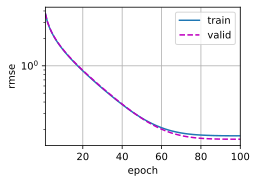

In [17]:
# 模型选择
# k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

训练log rmse：0.162325


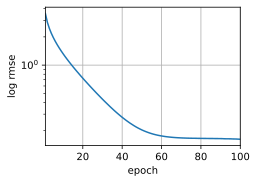

In [18]:
# 提交 Kaggle 预测
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    """
    训练神经网络模型并进行预测，并将预测结果导出为CSV文件。
    
    参数：
        train_features (torch.Tensor): 训练集特征数据
        test_features (torch.Tensor): 测试集特征数据
        train_labels (torch.Tensor): 训练集标签数据
        test_data (pd.DataFrame): 测试集数据
        num_epochs (int): 训练周期数
        lr (float): 学习率
        weight_decay (float): 权重衰减（L2正则化）系数
        batch_size (int): 批量大小
    
    返回：
        无
    
    执行训练、预测和结果导出操作。
    """
    net = get_net()  # 创建一个新的神经网络模型
    
    # 使用训练函数训练神经网络模型，获取训练集的对数均方根误差列表，忽略验证集的结果
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    
    # 绘制训练集对数均方根误差随训练周期的变化图表
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    
    # 打印训练集的最终对数均方根误差
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    
    # 对测试集特征数据进行预测，将预测结果从张量转换为NumPy数组
    preds = net(test_features).detach().numpy()
    
    # 将预测结果添加到测试数据的 'SalePrice' 列中
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    
    # 创建包含 'Id' 和 'SalePrice' 列的DataFrame，用于导出预测结果
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    
    # 将预测结果导出为CSV文件，不包含索引
    submission.to_csv('submission.csv', index=False)

# 注解：
# train_features: 训练集特征数据
# test_features: 测试集特征数据
# train_labels: 训练集标签数据
# test_data: 测试集数据
# num_epochs: 训练周期数
# lr: 学习率
# weight_decay: 权重衰减（L2正则化）系数
# batch_size: 批量大小
# get_net(): 创建一个新的神经网络模型
# train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size): 训练神经网络模型并评估性能
# d2l.plot(x, y, ...): 绘制数据图表
# float(train_ls[-1]): 将张量值转换为Python浮点数
# net(test_features): 对测试集特征数据进行预测
# detach(): 将张量从计算图中分离出来，不再追踪计算历史
# numpy(): 将张量转换为NumPy数组
# pd.Series(data): 创建一个Pandas Series对象
# preds.reshape(1, -1)[0]: 将预测结果的数组形状重新整理，并获取第一行作为一维数组
# pd.concat([test_data['Id'], test_data['SalePrice']], axis=1): 将两列数据拼接成一个DataFrame
# to_csv(file_path, index=False): 将DataFrame导出为CSV文件，不包含索引

train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

### 小结
- 真实数据通常混合了不同的数据类型，需要进行预处理
- **常用的预处理方法：将实值数据重新缩放为零均值和单位方差；用平均值替换缺失值**
- 将类别特征转换为指示符特征，可以是我们把这个特征当作一个独热向量来对待
- 可以使用 K 折交叉验证来选择模型并调整超参数
- **对数对于相对误差很有用**